# Arginine-glutamic acid dipeptide repeats (RERE)

The Arginine-glutamic acid dipeptide repeats (RERE) RERE gene encodes a nuclear receptor coregulator that positively regulates retinoic acid signaling [Fregeau et al., 2016](https://pubmed.ncbi.nlm.nih.gov/27087320/). A high percentage of RERE pathogenic variants affect a 21 amino acid (amino acids 1425–1445), histidine-rich region of the Atrophin-1 domain [Jordan et al., 2018](https://pubmed.ncbi.nlm.nih.gov/29330883/). The authors noted that Of the 19 individuals with NEDBEH described here and by Fregeau et al. (2016), nine (47%) carry sequence variants that affect a histidine-rich region of the Atrophin-1 domain that spans 21 amino acids (1425– 1445). The amino acid sequence in this region is 100% conserved down to Xenopus and zebrafish, but the functional significance of this domain is currently unknown.

It has been reported that point mutations in theatrophin-1 domain lead to a higher frequency of structural defects inthe brain, eye, heart, and kidney and sensorineural hearing loss ascompared to individuals with loss-of-function variants [Jordan et al., 2018](https://pubmed.ncbi.nlm.nih.gov/29330883/) and [Niehaus et al., 2022](https://pubmed.ncbi.nlm.nih.gov/36053530/).

Here we will perform an analysis similar to that shownin Table 3 of [Jordan et al (2018)](https://pubmed.ncbi.nlm.nih.gov/29330883/).

In [2]:
import gpsea
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo(release='v2023-10-09')
print(f'Loaded HPO v{hpo.version}')
print(f"Using genophenocorr version {gpsea.__version__}")

Loaded HPO v2023-10-09
Using genophenocorr version 0.9.1.dev0


### RERE
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for RERE.

In [3]:
gene_symbol = 'RERE'
mane_tx_id = 'NM_012102.4'
mane_protein_id = 'NP_036234.3' # FYVE, RhoGEF and PH domain-containing protein 1 [Homo sapiens]

In [4]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

phenopacket_store_release = '0.1.22' 
registry = configure_phenopacket_registry()

with registry.open_phenopacket_store(release=phenopacket_store_release) as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))


cohort_creator = configure_caching_cohort_creator(hpo)
cohort, qc = load_phenopackets(
    phenopackets=phenopackets, 
    cohort_creator=cohort_creator,
)

print(f'Loaded {len(cohort)} individuals: {gene_symbol}')
qc.summarize()

Individuals Processed: 100%|██████████| 22/22 [00:35<00:00,  1.64s/individuals]
Loaded 22 individuals: RERE
Validated under permissive policy
No errors or warnings were found


In [5]:
from gpsea.view import CohortViewer

cv = CohortViewer(hpo)
cv.process(cohort, transcript_id=mane_tx_id)

n,HPO Term
19,Global developmental delay
18,Intellectual disability
14,Autistic behavior
9,Hypotonia
7,Thin corpus callosum
6,Reduced cerebral white matter volume
6,Short stature
5,Ventricular septal defect
5,Strabismus
4,Scoliosis


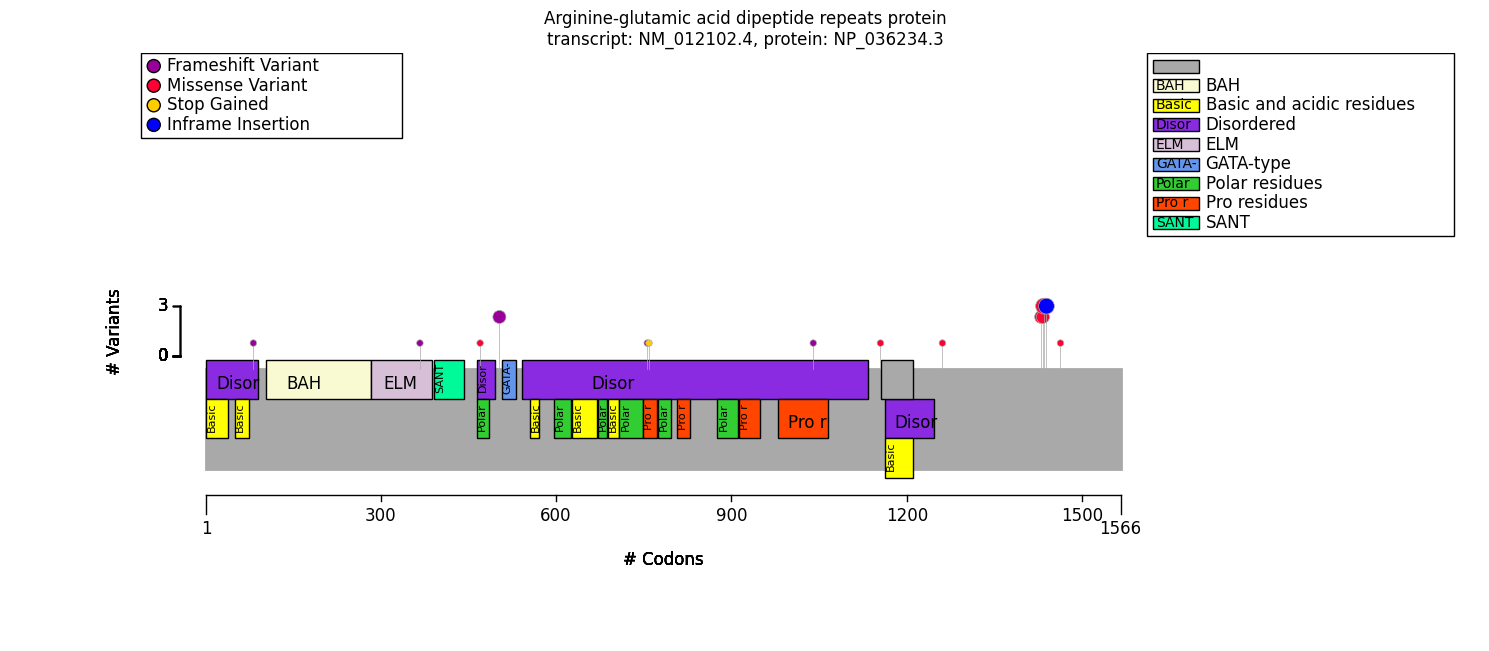

In [6]:
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_default_protein_metadata_service()
tx_coordinates = txc_service.fetch(mane_tx_id)
protein_meta = pms.annotate(mane_protein_id)
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt
rere_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
rere_fig.tight_layout();

In [7]:
from gpsea.view import ProteinVariantViewer

viewer = ProteinVariantViewer(protein_meta, mane_tx_id)
viewer.process(cohort)

Count,Name,Type,Coordinates,Variants
1,Disordered,Region,2 - 90,p.Ser84ValfsTer4
0,Basic and acidic residues,Compositional bias,2 - 38,
0,Basic and acidic residues,Compositional bias,51 - 75,
0,BAH,Domain,104 - 283,
1,ELM2,Domain,285 - 387,p.Leu369CysfsTer16
0,SANT,Domain,392 - 443,
1,Disordered,Region,465 - 495,p.Val471Ile
1,Polar residues,Compositional bias,465 - 486,p.Val471Ile
0,GATA-type,Zinc finger,508 - 532,
3,Disordered,Region,543 - 1133,p.Pro1041LeufsTer40; p.Gln760Ter; p.Thr758SerfsTer36


In [8]:
from gpsea.view import CohortVariantViewer

viewer = CohortVariantViewer(tx_id=mane_tx_id)
viewer.process(cohort)

Count,Variant key,HGVS,Overlapping Exons,Effects
3,1_8358216_8358216_T_TGGTGGA,c.4313_4318dup (p.Leu1438_His1439dup),21,inframe insertion
2,1_8358235_8358235_A_G,c.4300T>C (p.Ser1434Pro),21,missense
2,1_8364773_8364773_A_AC,c.1512dup (p.Tyr505ValfsTer37),15,frameshift
1,1_8359916_8359916_C_T,c.3466G>A (p.Gly1156Arg),20,missense
1,1_8361236_8361236_C_CCCTGGAGGAGCTGAGGAGGGAG,c.2249_2270dup (p.Thr758SerfsTer36),19,frameshift
1,1_8356195_8356195_T_C,c.4391A>G (p.His1464Arg),22,missense
1,1_8358750_8358750_G_C,c.3785C>G (p.Pro1262Arg),21,missense
1,1_8358231_8358231_T_A,c.4304A>T (p.His1435Leu),21,missense
1,1_8361229_8361229_G_A,c.2278C>T (p.Gln760Ter),19,stop gained
1,1_8358231_8358231_T_C,c.4304A>G (p.His1435Arg),21,missense


# Genotype-Phenotype Correlation (GPC) Analysis

[Jordan VK, et al (2018) Genotype-phenotype correlations in individuals with pathogenic RERE variants. Hum Mutat](https://pubmed.ncbi.nlm.nih.gov/29330883/) 

> evaluated the incidence of structural defects of the brain, eye, heart, and kidney and sensorineural hearing loss between 
individiuals with missense variants in the atrophin domain and those with other variants (Table 3).

They identified a significant correlation with the count of defects in these organ systems. We perform a U test to compare the counts of malformations in these organ systems both netween atrophin domain variants vs. other and
between frameshift variants and others. 

[Jordan VK, et al (2018)](https://pubmed.ncbi.nlm.nih.gov/29330883/) speculated that 

> the more severe phenotype, seen in cases with pathogenic missense variants in the atophin-1 domain, may be due to a dominant negative mechanism with genera-tion of abnormal protein product.

We use the following HPO terms

- [Abnormal brain morphology (HP:0012443)](https://hpo.jax.org/browse/term/HP:0012443)
- [Abnormal eye morphology (HP:0012372)](https://hpo.jax.org/browse/term/HP:0012372)
- [Abnormal heart morphology (HP:0001627)](https://hpo.jax.org/browse/term/HP:0001627)
- [Abnormal renal morphology (HP:0012210)](https://hpo.jax.org/browse/term/HP:0012210)
- [Sensorineural hearing impairment (HP:0000407)](https://hpo.jax.org/browse/term/HP:0000407)

In [9]:
from gpsea.analysis.clf import prepare_classifiers_for_terms_of_interest
from gpsea.analysis.pcats import configure_hpo_term_analysis

pheno_clfs = prepare_classifiers_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)
analysis = configure_hpo_term_analysis(hpo)

In [10]:
from gpsea.model import VariantEffect
from gpsea.model.genome import Region
from gpsea.analysis.predicate import protein_region
from gpsea.analysis.predicate import variant_effect, anyof
from gpsea.analysis.clf import monoallelic_classifier
from gpsea.view import MtcStatsViewer

# loss of function variants
lof_effects = (
    VariantEffect.TRANSCRIPT_ABLATION,
    VariantEffect.FRAMESHIFT_VARIANT,
    VariantEffect.START_LOST,
    VariantEffect.STOP_GAINED,
)
lof_mutation = anyof(variant_effect(eff, mane_tx_id) for eff in lof_effects)
atrophin_dom = protein_region(Region(1425, 1445), mane_tx_id)

lof_vs_atrophin_clf = monoallelic_classifier(
    a_predicate=lof_mutation,
    b_predicate=atrophin_dom,
    a_label="LoF",
    b_label="Atrophin")

lof_vs_atrophin_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=lof_vs_atrophin_clf,
    pheno_clfs=pheno_clfs
)


viewer = MtcStatsViewer()
viewer.process(lof_vs_atrophin_result)

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.4,80
HMF08,Skipping general term,81
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.4,261


In [11]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=lof_vs_atrophin_result)

Allele group                                      LoF         Atrophin  \
                                                Count Percent    Count   
Short stature [HP:0004322]                        0/5      0%      4/6   
Hypotonia [HP:0001252]                            1/8     12%     6/10   
Deeply set eye [HP:0000490]                       0/8      0%     4/10   
Ventriculomegaly [HP:0002119]                     0/4      0%      3/5   
Intellectual disability [HP:0001249]              5/7     71%      9/9   
Intrauterine growth retardation [HP:0001511]      0/6      0%      2/5   
Global developmental delay [HP:0001263]           6/8     75%      9/9   
Abnormal axial skeleton morphology [HP:0009121]   4/4    100%      5/5   
Autistic behavior [HP:0000729]                    5/6     83%      5/5   
Atypical behavior [HP:0000708]                    6/6    100%      6/6   
Neurodevelopmental delay [HP:0012758]             6/6    100%      9/9   
Neurodevelopmental abnormality [HP:0012759]       6/6    100%      9/9   

Allele group                                                                \
                                                Percent Corrected p values   
Short stature [HP:0004322]                          67%           0.352941   
Hypotonia [HP:0001252]                              60%           0.352941   
Deeply set eye [HP:0000490]                         40%           0.352941   
Ventriculomegaly [HP:0002119]                       60%           0.352941   
Intellectual disability [HP:0001249]               100%           0.352941   
Intrauterine growth retardation [HP:0001511]        40%           0.352941   
Global developmental delay [HP:0001263]            100%           0.352941   
Abnormal axial skeleton morphology [HP:0009121]    100%           1.000000   
Autistic behavior [HP:0000729]                     100%           1.000000   
Atypical behavior [HP:0000708]                     100%           1.000000   
Neurodevelopmental delay [HP:0012758]              100%           1.000000   
Neurodevelopmental abnormality [HP:0012759]        100%           1.000000   

Allele group                                               
                                                 p values  
Short stature [HP:0004322]                       0.060606  
Hypotonia [HP:0001252]                           0.065611  
Deeply set eye [HP:0000490]                      0.091503  
Ventriculomegaly [HP:0002119]                    0.166667  
Intellectual disability [HP:0001249]             0.175000  
Intrauterine growth retardation [HP:0001511]     0.181818  
Global developmental delay [HP:0001263]          0.205882  
Abnormal axial skeleton morphology [HP:0009121]  1.000000  
Autistic behavior [HP:0000729]                   1.000000  
Atypical behavior [HP:0000708]                   1.000000  
Neurodevelopmental delay [HP:0012758]            1.000000  
Neurodevelopmental abnormality [HP:0012759]      1.000000

In [12]:
from gpsea.analysis.pscore import CountingPhenotypeScorer
from gpsea.analysis.pscore.stats import MannWhitneyStatistic
from gpsea.analysis.pscore import PhenotypeScoreAnalysis

select_hpo = ("HP:0012443", "HP:0012372","HP:0001627","HP:0012210", "HP:0000407")

scorer = CountingPhenotypeScorer.from_query_curies(hpo, select_hpo)
score_stats = MannWhitneyStatistic()
score_analysis = PhenotypeScoreAnalysis(score_stats)
atrophin_score_results = score_analysis.compare_genotype_vs_phenotype_score(cohort, lof_vs_atrophin_clf, scorer)
atrophin_pval = atrophin_score_results.pval
print(f"Atrophin domain, p-val: {atrophin_pval:.4f}")

Atrophin domain, p-val: 0.0014


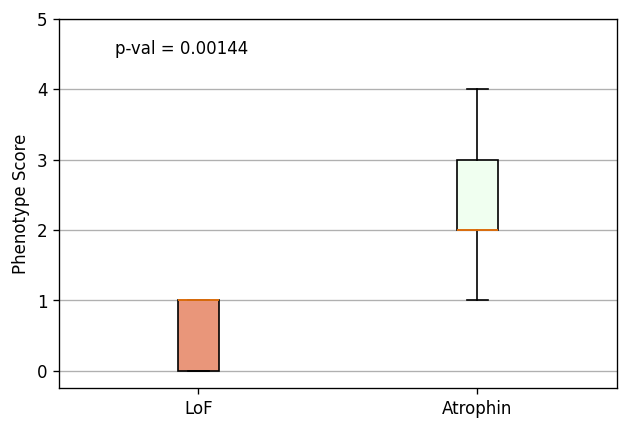

In [13]:
import matplotlib.pyplot as plt 

atrophin_score_fig, ax = plt.subplots(figsize = (6,4), dpi = 120)
atrophin_score_results.plot_boxplots(ax=ax)
ax.text(x=0.7, y=4.5, s=f"p-val = {atrophin_pval:.5f}")
_= ax.grid(axis="y")
_= ax.set(ylabel="Phenotype Score", ylim=(-0.25, 5))

In [14]:
from gpseacs.report import GpseaAnalysisReport, GPAnalysisResultSummary


f_results = (
    GPAnalysisResultSummary.from_multi(
        result=lof_vs_atrophin_result
    ),
)

m_results = (
    GPAnalysisResultSummary.from_mono(
        result=atrophin_score_results
    ),
)


report = GpseaAnalysisReport(name=gene_symbol, 
                             cohort=cohort, 
                             fet_results=f_results,
                             mono_results=m_results,
                             gene_symbol=gene_symbol,
                             mane_tx_id=mane_tx_id,
                             mane_protein_id=mane_protein_id)

In [15]:
from gpseacs.report import GpseaNotebookSummarizer
summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

ValueError: The 'gpseacs' package was not installed in a way that PackageLoader understands.

In [15]:
summarizer.process_latex(report=report, protein_fig=rere_fig, stats_fig=atrophin_score_fig)

Figure saved to ../../supplement/img/RERE_protein_diagram-draft.pdf
Figure saved to ../../supplement/img/RERE_stats-draft.pdf
Output to ../../supplement/tex/RERE_summary_draft.tex
